In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import roc_curve, auc

import joblib

In [3]:
# Data for cls 4
df = pd.read_csv("/content/cluster_4.csv")
df.head()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability,Cluster,Bankrupt?,Index
0,0.483401,0.556694,0.536164,0.602445,0.602445,0.999035,0.797458,0.809380,0.303506,0.781633,...,0.602444,0.841891,0.293391,0.027063,0.566190,1,0.015406,4,0,3
1,0.465071,0.533689,0.516944,0.594740,0.594740,0.998962,0.797393,0.809313,0.303544,0.781572,...,0.594736,0.840085,0.285529,0.029521,0.568791,1,0.019155,4,0,6
2,0.514649,0.579972,0.565983,0.614112,0.613990,0.999064,0.797502,0.809414,0.303521,0.781680,...,0.614110,0.842268,0.281334,0.026958,0.565847,1,0.024784,4,0,44
3,0.518842,0.592183,0.574121,0.616901,0.616901,0.999235,0.797703,0.809599,0.303515,0.781881,...,0.616897,0.844463,0.290621,0.026799,0.565197,1,0.016305,4,0,53
4,0.476966,0.545083,0.527651,0.610019,0.610019,0.999096,0.797529,0.809422,0.303502,0.781690,...,0.610016,0.841044,0.282803,0.026798,0.565189,1,0.022151,4,0,56


In [4]:
X = df.drop(columns=["Index", "Cluster", "Bankrupt?"])
y = df["Bankrupt?"]


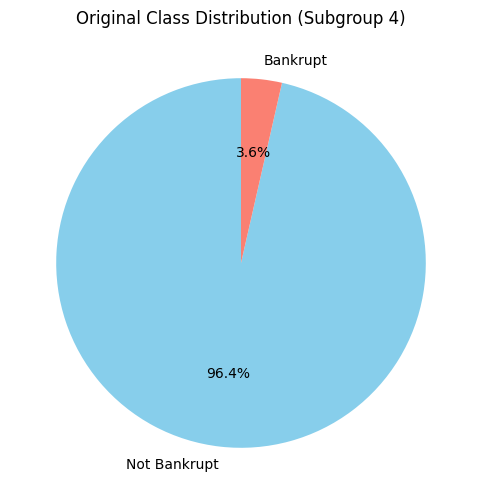

In [5]:
#  Original Class Balance
plt.figure(figsize=(6,6))
y.value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'], labels=["Not Bankrupt", "Bankrupt"])
plt.title("Original Class Distribution (Subgroup 4)")
plt.ylabel("")
plt.show()

In [6]:
# Standardize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

In [7]:
# Remove highly corr features
corr = X_scaled_df.corr()
high_corr_features = set()
for j in range(len(corr.columns)):
    for i in range(j):
        if abs(corr.iloc[j, i]) > 0.95:
            high_corr_features.add(corr.columns[j])

X_reduced = X_scaled_df.drop(columns=high_corr_features)


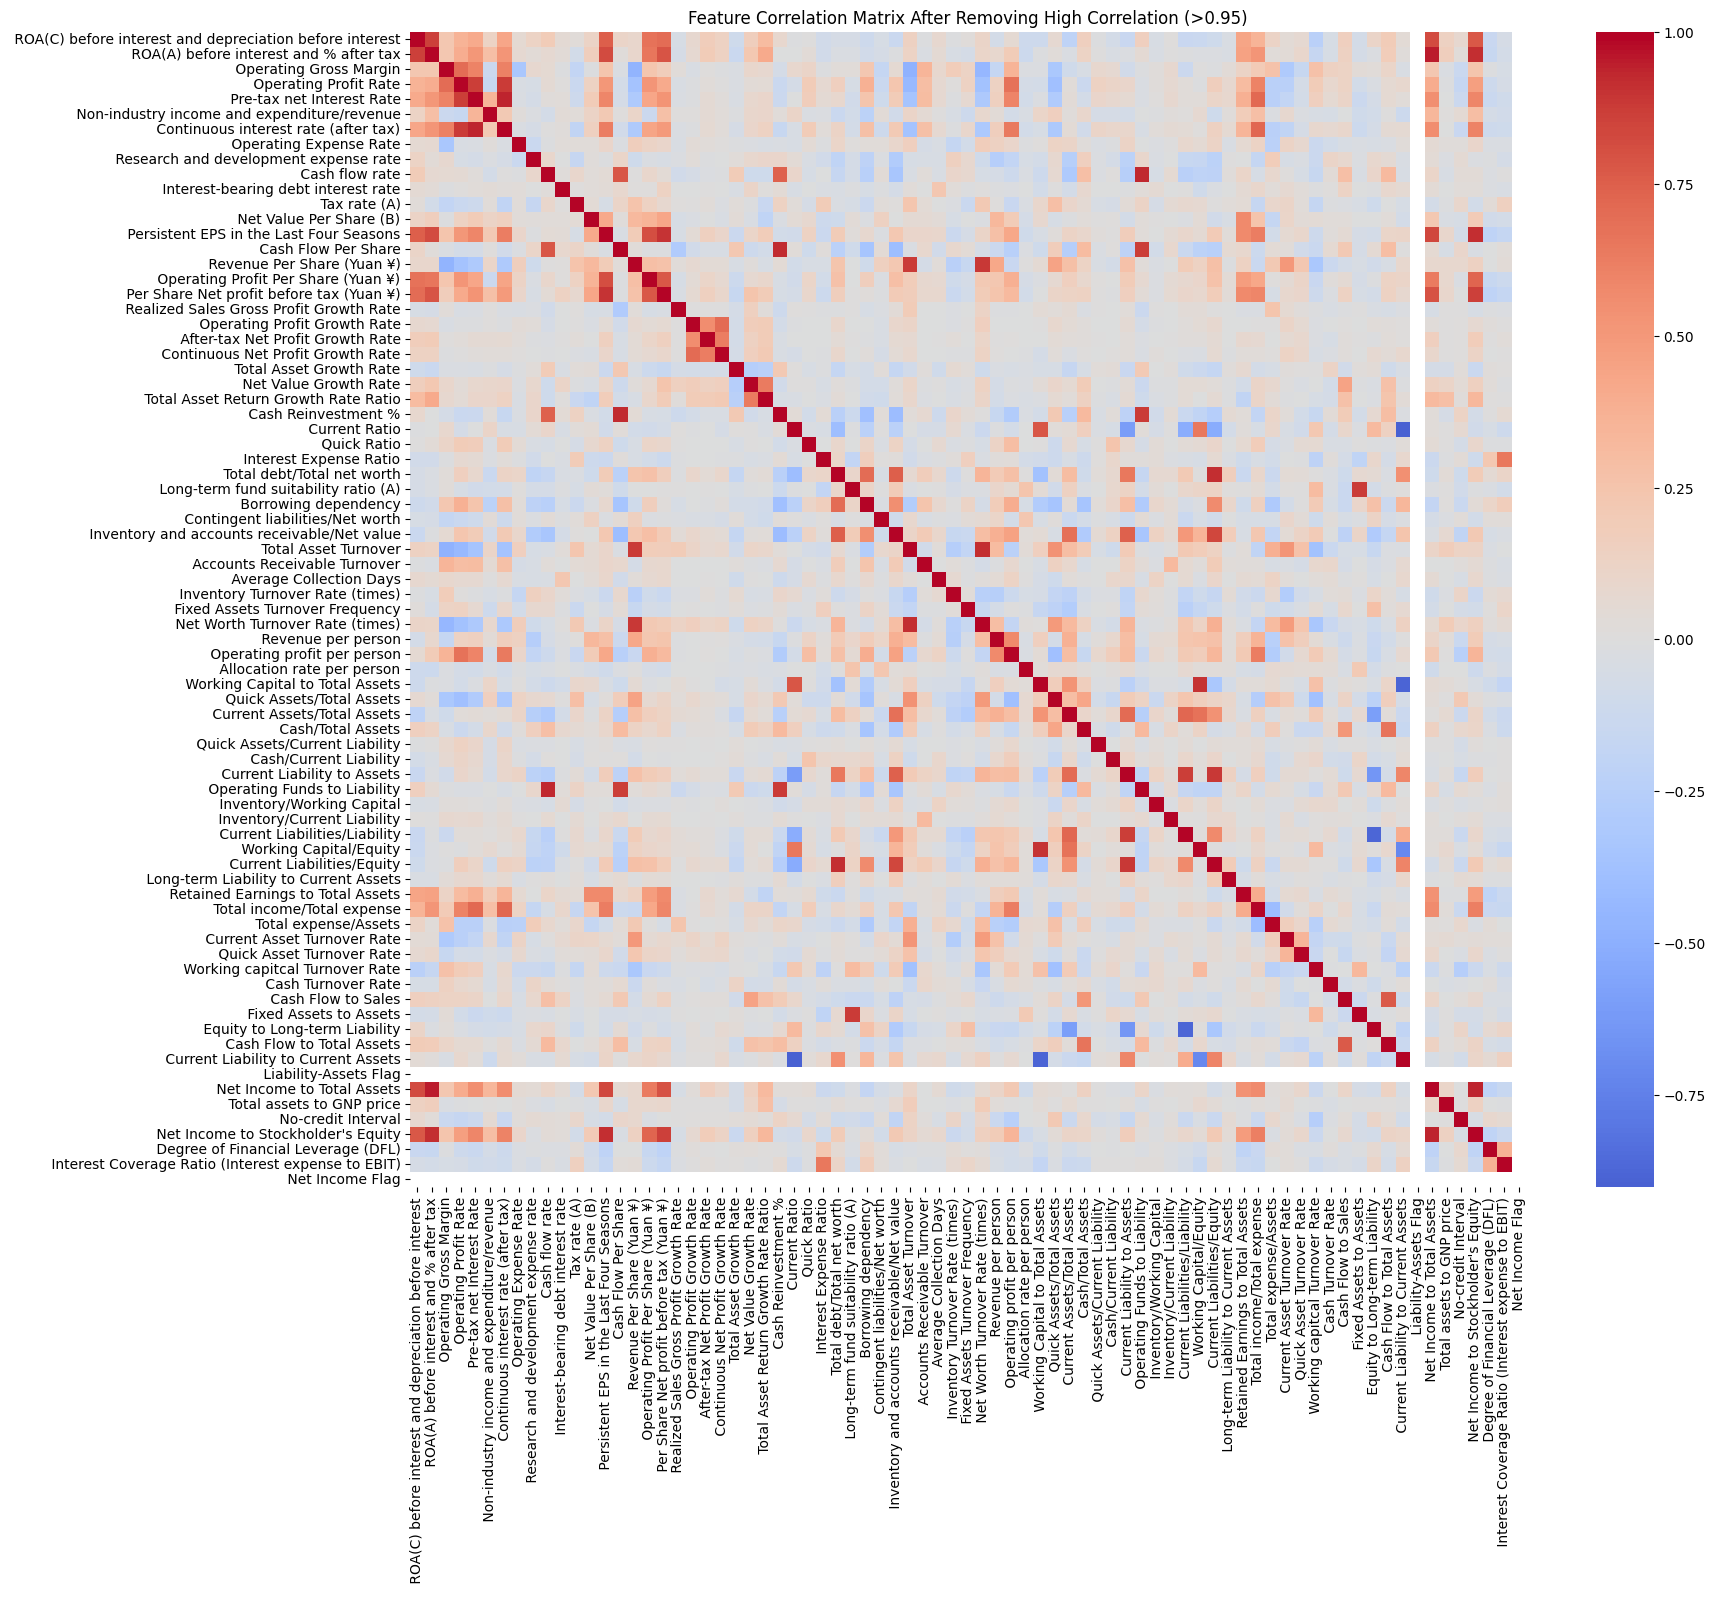

In [8]:
# Correlation Matrix
plt.figure(figsize=(18,15))
sns.heatmap(X_reduced.corr(), cmap='coolwarm', center=0)
plt.title("Feature Correlation Matrix After Removing High Correlation (>0.95)")
plt.show()

In [9]:
# Mutual Information
mi_scores = mutual_info_classif(X_reduced, y, random_state=42)
mi_df = pd.DataFrame({"Feature": X_reduced.columns, "MI": mi_scores})
selected_features = mi_df[mi_df["MI"] > 0.01].head(12)["Feature"].tolist()

In [10]:
# Final Selected Features
X_selected = X_reduced[selected_features]
print(f"Selected {len(selected_features)} final features.")

Selected 12 final features.


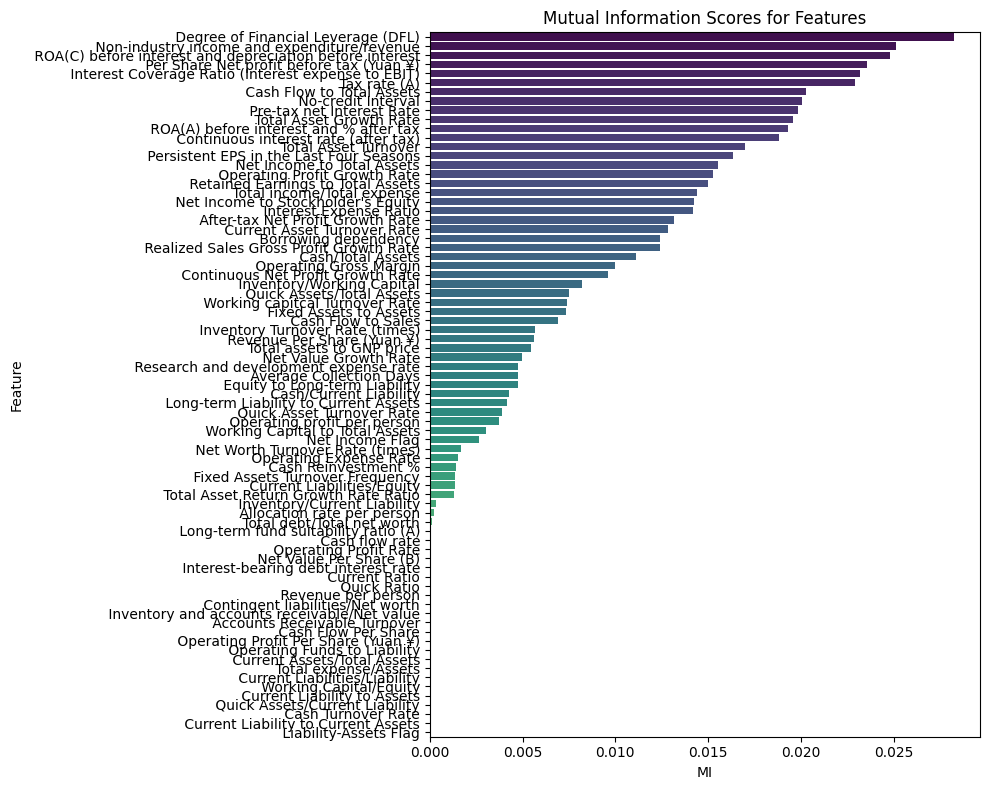

In [11]:
# MI Scores
plt.figure(figsize=(10,8))
sns.barplot(x="MI", y="Feature", data=mi_df.sort_values(by="MI", ascending=False), palette="viridis")
plt.title("Mutual Information Scores for Features")
plt.tight_layout()
plt.show()

In [12]:
# Base Models
base_models = [
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42)),
    ('dt', DecisionTreeClassifier(class_weight='balanced', random_state=42))
]

In [13]:
# Meta Model (Logistic Regression)
meta_model = LogisticRegression(class_weight='balanced', random_state=42)

# Stacking Classifier
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Train Stacking Classifier
stacked_model.fit(X_selected, y)


StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(class_weight='balanced',
                                                       random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(random_state=42)),
                               ('dt',
                                DecisionTreeClassifier(class_weight='balanced',
                                                       random_state=42))],
                   final_estimator=LogisticRegression(class_weight='balanced',
                                                      random_state=42))

In [14]:
# Eval Base Models
print("\n--- Base Models Evaluation ---\n")
for name, model in base_models:
    model.fit(X_selected, y)
    y_pred_base = model.predict(X_selected)
    cm_base = confusion_matrix(y, y_pred_base)
    TT_base = cm_base[1, 1]
    TF_base = cm_base[1, 0]
    acc_base = TT_base / (TT_base + TF_base) if (TT_base + TF_base) > 0 else 0
    print(f"{name.upper()} - TT: {TT_base}, TF: {TF_base}, Accuracy (acc): {acc_base:.4f}")



--- Base Models Evaluation ---

RF - TT: 26, TF: 0, Accuracy (acc): 1.0000
GB - TT: 26, TF: 0, Accuracy (acc): 1.0000
DT - TT: 26, TF: 0, Accuracy (acc): 1.0000


In [15]:

# Eval Meta Model
print("\n--- Meta Model Evaluation ---\n")
y_pred_meta = stacked_model.predict(X_selected)
cm_meta = confusion_matrix(y, y_pred_meta)
TT_meta = cm_meta[1, 1]
TF_meta = cm_meta[1, 0]
acc_meta = TT_meta / (TT_meta + TF_meta) if (TT_meta + TF_meta) > 0 else 0
print(classification_report(y, y_pred_meta))
print(f"\nMeta Model - TT: {TT_meta}, TF: {TF_meta}, Accuracy (acc): {acc_meta:.4f}")


--- Meta Model Evaluation ---

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       704
           1       0.70      1.00      0.83        26

    accuracy                           0.98       730
   macro avg       0.85      0.99      0.91       730
weighted avg       0.99      0.98      0.99       730


Meta Model - TT: 26, TF: 0, Accuracy (acc): 1.0000


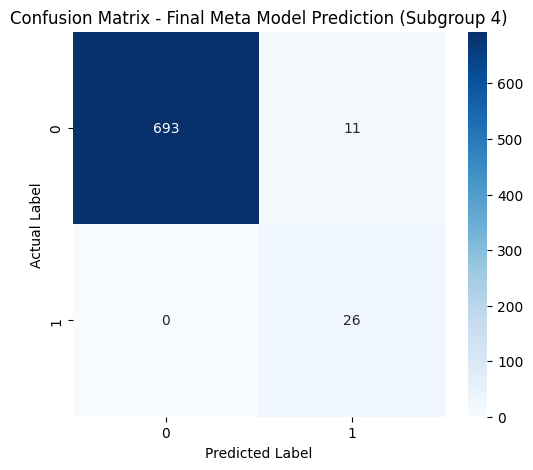

In [16]:
# Final Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_meta, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Final Meta Model Prediction (Subgroup 4)")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

In [18]:
from sklearn.pipeline import Pipeline


In [20]:
# Build pipeline for export
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5))
])

# Refit full pipeline
pipeline.fit(X[selected_features], y)
joblib.dump(pipeline, "subgroup_4_model.pkl")
print("\n Pipeline with model saved as 'subgroup_4_model.pkl'")



 Pipeline with model saved as 'subgroup_4_model.pkl'


In [ ]:
# import pickle

In [ ]:
# with open('subgroup_4_model.pkl', 'wb') as f:
    # pickle.dump(stacked_model, f)